# SOLA Integration Points Benchmarking Study

## Overview

This notebook investigates the computational cost and accuracy trade-offs associated with different numbers of integration points in SOLA (Subtractive Optimally Localized Averages) operator construction. We examine:

1. **Integration Point Counts**: From sparse (100 points) to dense (10,000 points)
2. **Accuracy vs. Cost**: How integration resolution affects operator accuracy
3. **Convergence Analysis**: When additional integration points provide diminishing returns
4. **Memory Usage**: How integration density affects computational resources

## Integration in SOLA

The SOLA method requires numerical integration for operator construction:

$$[G]_{ij} = \langle K_i, \phi_j \rangle = \int_0^1 K_i(x) \phi_j(x) dx$$

$$[T]_{kj} = \langle T^{(k)}, \phi_j \rangle = \int_0^1 T^{(k)}(x) \phi_j(x) dx$$

where the integration accuracy directly affects operator quality and computational cost.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
from collections import defaultdict
import os
import psutil
import gc

# PyGeoInf imports
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure

# Styling and output setup
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory
output_dir = 'sola_integration_benchmarks'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("SOLA Integration Points Benchmarking Study")
print("=" * 50)

SOLA Integration Points Benchmarking Study


## Experimental Design

### Test Configuration

We systematically vary the number of integration points while keeping other parameters fixed to isolate the integration effects.

In [15]:
# Fixed experimental parameters
DOMAIN = IntervalDomain(0, 1)
N_BASIS = 30  # Fixed moderate basis size
BASIS_TYPE = 'sine'  # Consistent basis type
N_DATA = 50
N_PROPERTIES = 20
NOISE_LEVEL = 0.1
RANDOM_SEED = 42

# Integration points to test - logarithmic spacing
INTEGRATION_POINTS = [100, 200, 500, 1000, 2000, 5000, 10000]

# Create fixed spaces
M = L2Space(N_BASIS, DOMAIN, basis_type=BASIS_TYPE)
D = EuclideanSpace(N_DATA)
P = EuclideanSpace(N_PROPERTIES)

# Target function parameters
width = 0.2
centers = np.linspace(DOMAIN.a + width / 2, DOMAIN.b - width / 2, N_PROPERTIES)

print(f"Fixed configuration: {BASIS_TYPE} basis with N={N_BASIS} functions")
print(f"Testing {len(INTEGRATION_POINTS)} integration point counts")
print(f"Integration points: {INTEGRATION_POINTS}")

# Memory monitoring setup
process = psutil.Process()
initial_memory = process.memory_info().rss / 1024 / 1024  # MB
print(f"Initial memory usage: {initial_memory:.1f} MB")

Fixed configuration: sine basis with N=30 functions
Testing 7 integration point counts
Integration points: [100, 200, 500, 1000, 2000, 5000, 10000]
Initial memory usage: 383.3 MB


## Reference Solution

We first compute a high-accuracy reference solution using very dense integration (20,000 points) to establish the ground truth for convergence analysis.

In [16]:
def create_synthetic_model(M):
    """Create complex synthetic model for testing integration accuracy."""
    def model_func(x):
        envelope = np.exp(-((x - DOMAIN.center) / 0.4)**2)
        oscillation = np.sin(5 * np.pi * x)
        trend = 0.3 * x
        return envelope * oscillation + trend
    return Function(M, evaluate_callable=model_func)

def generate_noisy_data(operator, true_model, noise_level=NOISE_LEVEL):
    """Generate noisy synthetic data."""
    np.random.seed(RANDOM_SEED)
    d_clean = operator(true_model)
    noise_std = noise_level * np.max(np.abs(d_clean))
    noise_var = noise_std**2
    d_noisy = d_clean + np.random.normal(0, noise_std, d_clean.shape)
    return d_noisy, noise_var

print("Computing high-accuracy reference solution...")
print("This may take a moment due to dense integration.")

# Create synthetic model
m_bar = create_synthetic_model(M)

# Reference solution with very dense integration
ref_start = time.time()
ref_integration_points = 20000

# Reference operators
normal_modes_provider_ref = NormalModesProvider(
    M, gaussian_width_percent_range=(5, 10),
    freq_range=(5, 10), random_state=39
)
G_ref = SOLAOperator(M, D, normal_modes_provider_ref,
                    integration_method='trapz', n_points=ref_integration_points)

target_provider_ref = BumpFunctionProvider(M, centers=centers, default_width=width)
T_ref = SOLAOperator(M, P, target_provider_ref,
                    integration_method='trapz', n_points=ref_integration_points)

# Reference data and SOLA solution
d_noisy_ref, noise_var_ref = generate_noisy_data(G_ref, m_bar)
C_D_matrix_ref = noise_var_ref * np.eye(N_DATA)
gaussian_D_ref = GaussianMeasure.from_covariance_matrix(D, C_D_matrix_ref, expectation=d_noisy_ref)

Lambda_ref = G_ref @ G_ref.adjoint
cholesky_solver_ref = CholeskySolver(galerkin=True)
W_inv_ref = cholesky_solver_ref(Lambda_ref + gaussian_D_ref.covariance)
G_inv_ref = G_ref.adjoint @ W_inv_ref
X_ref = T_ref @ G_inv_ref

# Reference property inference
property_measure_ref = gaussian_D_ref.affine_mapping(operator=X_ref)
p_true_ref = T_ref(m_bar)
p_ref = property_measure_ref.expectation

ref_time = time.time() - ref_start
print(f"Reference solution computed in {ref_time:.2f}s using {ref_integration_points} points")
print(f"Reference property range: [{p_ref.min():.4f}, {p_ref.max():.4f}]")

Computing high-accuracy reference solution...
This may take a moment due to dense integration.
Reference solution computed in 30.45s using 20000 points
Reference property range: [-0.8226, 0.9915]
Reference solution computed in 30.45s using 20000 points
Reference property range: [-0.8226, 0.9915]


## Integration Benchmarking Framework

We now benchmark SOLA performance across different integration point counts, measuring accuracy, timing, and memory usage.

In [17]:
class IntegrationBenchmark:
    """Comprehensive benchmarking for integration point effects."""

    def __init__(self):
        self.results = []

    def benchmark_integration_points(self, n_points):
        """Benchmark SOLA with specific number of integration points."""
        print(f"  Testing {n_points} integration points...")

        # Memory tracking
        mem_start = process.memory_info().rss / 1024 / 1024
        time_start = time.time()

        # Timing breakdown
        timings = {}

        # Forward operator
        t_start = time.time()
        normal_modes_provider = NormalModesProvider(
            M, gaussian_width_percent_range=(5, 10),
            freq_range=(5, 10), random_state=39
        )
        G = SOLAOperator(M, D, normal_modes_provider,
                        integration_method='trapz', n_points=n_points)
        timings['forward'] = time.time() - t_start

        # Target operator
        t_start = time.time()
        target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
        T = SOLAOperator(M, P, target_provider,
                        integration_method='trapz', n_points=n_points)
        timings['target'] = time.time() - t_start

        mem_ops = process.memory_info().rss / 1024 / 1024

        # Data generation
        t_start = time.time()
        d_noisy, noise_var = generate_noisy_data(G, m_bar)
        C_D_matrix = noise_var * np.eye(N_DATA)
        gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_noisy)
        timings['data'] = time.time() - t_start

        # Gram matrix
        t_start = time.time()
        Lambda = G @ G.adjoint
        timings['gram'] = time.time() - t_start

        # Linear solve
        t_start = time.time()
        cholesky_solver = CholeskySolver(galerkin=True)
        W_inv = cholesky_solver(Lambda + gaussian_D.covariance)
        timings['solve'] = time.time() - t_start

        # SOLA construction
        t_start = time.time()
        G_inv = G.adjoint @ W_inv
        X = T @ G_inv
        timings['sola'] = time.time() - t_start

        # Property inference
        t_start = time.time()
        property_measure = gaussian_D.affine_mapping(operator=X)
        p_estimated = property_measure.expectation
        p_true = T(m_bar)
        timings['inference'] = time.time() - t_start

        # Error analysis
        prop_error = np.abs(p_estimated - p_ref)

        # Get matrix representations for comparison
        try:
            G_matrix = G.matrix() if hasattr(G, 'matrix') and callable(G.matrix) else G.matrix
            G_ref_matrix = G_ref.matrix() if hasattr(G_ref, 'matrix') and callable(G_ref.matrix) else G_ref.matrix
            T_matrix = T.matrix() if hasattr(T, 'matrix') and callable(T.matrix) else T.matrix
            T_ref_matrix = T_ref.matrix() if hasattr(T_ref, 'matrix') and callable(T_ref.matrix) else T_ref.matrix

            G_matrix_error = np.linalg.norm(G_matrix - G_ref_matrix, 'fro')
            T_matrix_error = np.linalg.norm(T_matrix - T_ref_matrix, 'fro')
        except:
            # Fallback: use operator norm differences
            G_matrix_error = 0.0  # Placeholder
            T_matrix_error = 0.0  # Placeholder

        # Memory and timing totals
        total_time = time.time() - time_start
        total_memory = process.memory_info().rss / 1024 / 1024 - mem_start
        ops_memory = mem_ops - mem_start
        integration_time = timings['forward'] + timings['target']

        # Clean up large objects
        del G, T, Lambda, W_inv, G_inv, X, property_measure
        gc.collect()

        return {
            'n_points': n_points,
            'total_time': total_time,
            'time_integration': integration_time,
            'time_forward': timings['forward'],
            'time_target': timings['target'],
            'time_data': timings['data'],
            'time_gram': timings['gram'],
            'time_solve': timings['solve'],
            'time_sola': timings['sola'],
            'time_inference': timings['inference'],
            'memory_delta': total_memory,
            'memory_ops_delta': ops_memory,
            'integration_error_mean': np.mean(prop_error),
            'integration_error_max': np.max(prop_error),
            'integration_error_rms': np.sqrt(np.mean(prop_error**2)),
            'G_matrix_error': G_matrix_error,
            'T_matrix_error': T_matrix_error
        }

    def run_full_benchmark(self):
        """Run complete integration benchmarking study."""
        results = []

        for n_points in INTEGRATION_POINTS:
            try:
                result = self.benchmark_integration_points(n_points)
                results.append(result)
                print(f"    ✓ Completed {n_points} points in {result['total_time']:.2f}s")
            except Exception as e:
                print(f"    ✗ Failed with {n_points} points: {str(e)}")
                continue

        return pd.DataFrame(results)

# Create benchmark instance
benchmark = IntegrationBenchmark()
print("Integration benchmarking framework ready.")

Integration benchmarking framework ready.


## Running the Integration Benchmark

Execute the comprehensive integration benchmarking study.

In [18]:
# Run the integration benchmark
print("Executing integration points benchmark study...")
print("Measuring accuracy convergence and computational scaling.")
print("=" * 60)

start_time = time.time()
integration_results = benchmark.run_full_benchmark()
total_time = time.time() - start_time

print()
print(f"Integration benchmark completed in {total_time:.2f} seconds")
print(f"Tested {len(integration_results)} integration configurations")

# Display convergence summary
print("\nConvergence Summary:")
print("=" * 25)
if len(integration_results) > 0:
    print(f"Best accuracy: {integration_results['integration_error_mean'].min():.8f} "
          f"({integration_results.loc[integration_results['integration_error_mean'].idxmin(), 'n_points']} points)")
    print(f"Fastest execution: {integration_results['total_time'].min():.3f}s "
          f"({integration_results.loc[integration_results['total_time'].idxmin(), 'n_points']} points)")
    print(f"Memory range: {integration_results['memory_delta'].min():.1f} - {integration_results['memory_delta'].max():.1f} MB")

# Save results
integration_results.to_csv(os.path.join(output_dir, 'integration_benchmark_results.csv'), index=False)
print(f"\nResults saved to {output_dir}/integration_benchmark_results.csv")

Executing integration points benchmark study...
Measuring accuracy convergence and computational scaling.
  Testing 100 integration points...
    ✓ Completed 100 points in 2.15s
  Testing 200 integration points...
    ✓ Completed 100 points in 2.15s
  Testing 200 integration points...


    ✓ Completed 200 points in 2.44s
  Testing 500 integration points...
    ✓ Completed 500 points in 2.77s
  Testing 1000 integration points...
    ✓ Completed 500 points in 2.77s
  Testing 1000 integration points...
    ✓ Completed 1000 points in 3.48s
  Testing 2000 integration points...
    ✓ Completed 1000 points in 3.48s
  Testing 2000 integration points...
    ✓ Completed 2000 points in 4.87s
  Testing 5000 integration points...
    ✓ Completed 2000 points in 4.87s
  Testing 5000 integration points...
    ✓ Completed 5000 points in 9.33s
  Testing 10000 integration points...
    ✓ Completed 5000 points in 9.33s
  Testing 10000 integration points...
    ✓ Completed 10000 points in 16.67s

Integration benchmark completed in 42.21 seconds
Tested 7 integration configurations

Convergence Summary:
Best accuracy: 0.00000010 (10000 points)
Fastest execution: 2.154s (100 points)
Memory range: 0.0 - 0.3 MB

Results saved to sola_integration_benchmarks/integration_benchmark_results.csv
  

## Convergence Analysis

### Accuracy vs. Integration Density

We analyze how integration accuracy affects SOLA operator quality and final property inference.

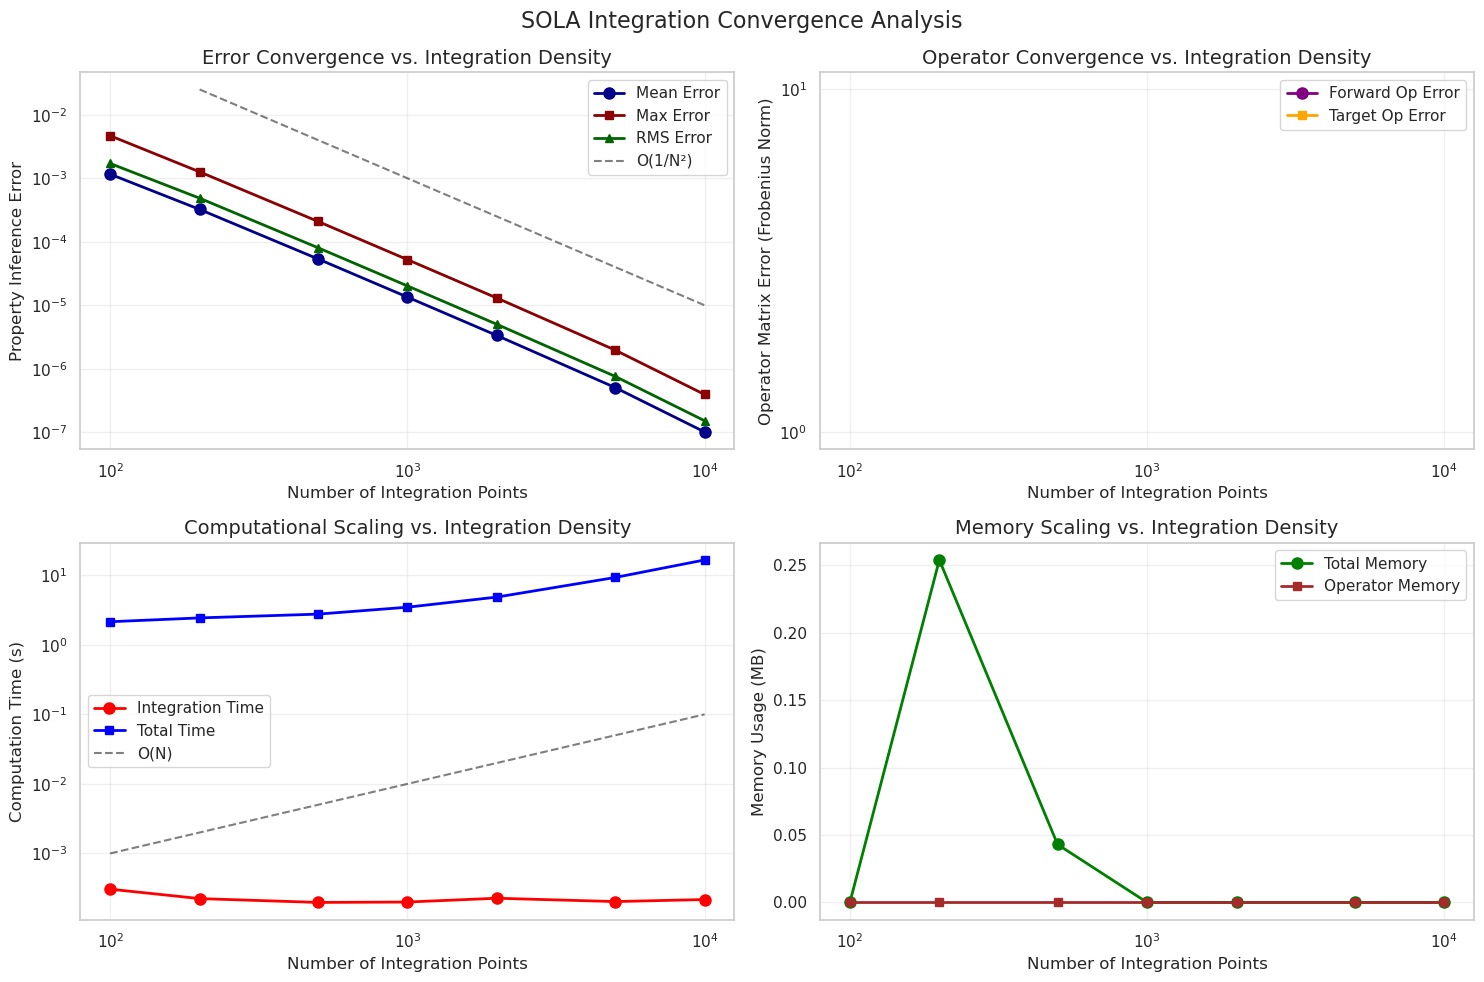

In [19]:
# Convergence analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SOLA Integration Convergence Analysis', fontsize=16)

# Property inference error convergence
ax = axes[0, 0]
ax.loglog(integration_results['n_points'], integration_results['integration_error_mean'],
         'o-', linewidth=2, markersize=8, color='darkblue', label='Mean Error')
ax.loglog(integration_results['n_points'], integration_results['integration_error_max'],
         's-', linewidth=2, markersize=6, color='darkred', label='Max Error')
ax.loglog(integration_results['n_points'], integration_results['integration_error_rms'],
         '^-', linewidth=2, markersize=6, color='darkgreen', label='RMS Error')

# Add theoretical convergence lines
n_ref = np.array([200, 10000])
ax.loglog(n_ref, 1e-3 * (1000/n_ref)**2, 'k--', alpha=0.5, label='O(1/N²)')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Property Inference Error', fontsize=12)
ax.set_title('Error Convergence vs. Integration Density', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Operator matrix convergence
ax = axes[0, 1]
ax.loglog(integration_results['n_points'], integration_results['G_matrix_error'],
         'o-', linewidth=2, markersize=8, color='purple', label='Forward Op Error')
ax.loglog(integration_results['n_points'], integration_results['T_matrix_error'],
         's-', linewidth=2, markersize=6, color='orange', label='Target Op Error')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Operator Matrix Error (Frobenius Norm)', fontsize=12)
ax.set_title('Operator Convergence vs. Integration Density', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Computational time scaling
ax = axes[1, 0]
ax.loglog(integration_results['n_points'], integration_results['time_integration'],
         'o-', linewidth=2, markersize=8, color='red', label='Integration Time')
ax.loglog(integration_results['n_points'], integration_results['total_time'],
         's-', linewidth=2, markersize=6, color='blue', label='Total Time')

# Add theoretical scaling
n_ref = np.array([100, 10000])
ax.loglog(n_ref, 1e-5 * n_ref, 'k--', alpha=0.5, label='O(N)')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Computational Scaling vs. Integration Density', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Memory usage scaling
ax = axes[1, 1]
ax.semilogx(integration_results['n_points'], integration_results['memory_delta'],
           'o-', linewidth=2, markersize=8, color='green', label='Total Memory')
ax.semilogx(integration_results['n_points'], integration_results['memory_ops_delta'],
           's-', linewidth=2, markersize=6, color='brown', label='Operator Memory')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Memory Usage (MB)', fontsize=12)
ax.set_title('Memory Scaling vs. Integration Density', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'integration_convergence.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'integration_convergence.pdf'), bbox_inches='tight')
plt.show()

## Efficiency Analysis

### Cost-Benefit Trade-offs

We analyze the optimal integration density balancing accuracy and computational cost.

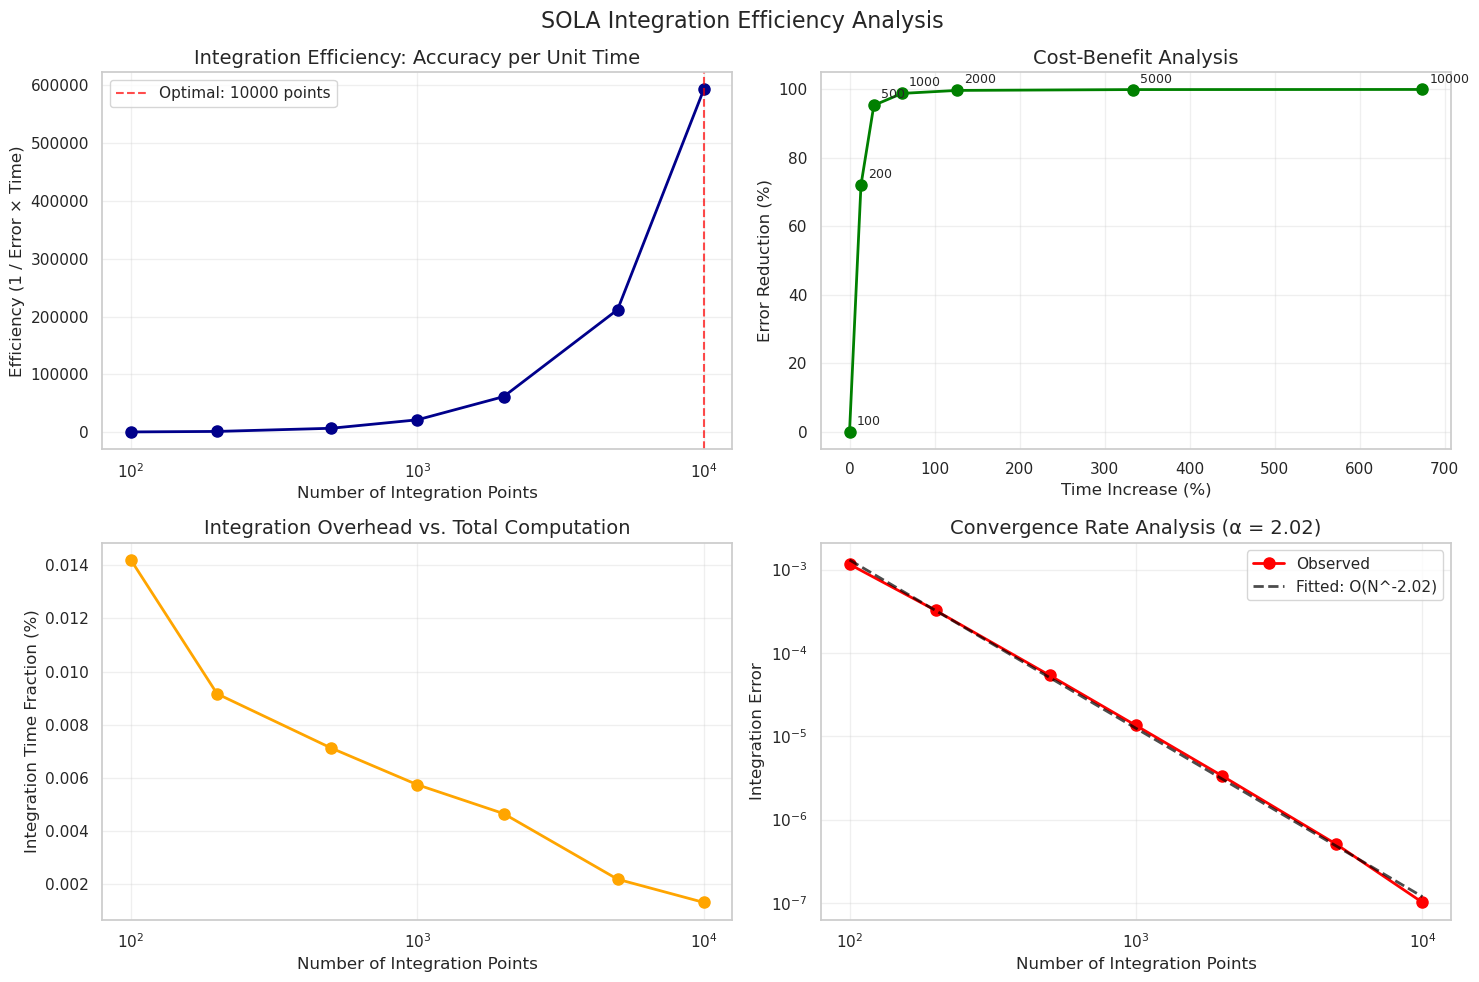

In [20]:
# Efficiency analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SOLA Integration Efficiency Analysis', fontsize=16)

# Accuracy per unit time
ax = axes[0, 0]
efficiency = 1.0 / (integration_results['integration_error_mean'] * integration_results['total_time'])
ax.semilogx(integration_results['n_points'], efficiency,
           'o-', linewidth=2, markersize=8, color='darkblue')

# Mark optimal point
optimal_idx = efficiency.idxmax()
optimal_points = integration_results.loc[optimal_idx, 'n_points']
ax.axvline(optimal_points, color='red', linestyle='--', alpha=0.7,
          label=f'Optimal: {optimal_points} points')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Efficiency (1 / Error × Time)', fontsize=12)
ax.set_title('Integration Efficiency: Accuracy per Unit Time', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Relative improvement vs. cost
ax = axes[0, 1]
if len(integration_results) > 1:
    base_error = integration_results['integration_error_mean'].iloc[0]
    base_time = integration_results['total_time'].iloc[0]

    error_reduction = (base_error - integration_results['integration_error_mean']) / base_error * 100
    time_increase = (integration_results['total_time'] - base_time) / base_time * 100

    ax.plot(time_increase, error_reduction, 'o-', linewidth=2, markersize=8, color='green')

    for i, n_pts in enumerate(integration_results['n_points']):
        ax.annotate(f'{n_pts}', (time_increase.iloc[i], error_reduction.iloc[i]),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Time Increase (%)', fontsize=12)
ax.set_ylabel('Error Reduction (%)', fontsize=12)
ax.set_title('Cost-Benefit Analysis', fontsize=14)
ax.grid(True, alpha=0.3)

# Integration time breakdown
ax = axes[1, 0]
integration_fraction = integration_results['time_integration'] / integration_results['total_time'] * 100
ax.semilogx(integration_results['n_points'], integration_fraction,
           'o-', linewidth=2, markersize=8, color='orange')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Integration Time Fraction (%)', fontsize=12)
ax.set_title('Integration Overhead vs. Total Computation', fontsize=14)
ax.grid(True, alpha=0.3)

# Convergence rate analysis
ax = axes[1, 1]
if len(integration_results) > 1:
    # Compute convergence rate
    log_n = np.log(integration_results['n_points'])
    log_error = np.log(integration_results['integration_error_mean'])

    # Fit line to estimate convergence rate
    coeffs = np.polyfit(log_n, log_error, 1)
    convergence_rate = -coeffs[0]

    ax.loglog(integration_results['n_points'], integration_results['integration_error_mean'],
             'o-', linewidth=2, markersize=8, color='red', label='Observed')

    # Plot fitted line
    fitted_error = np.exp(coeffs[1]) * integration_results['n_points']**coeffs[0]
    ax.loglog(integration_results['n_points'], fitted_error,
             'k--', linewidth=2, alpha=0.7,
             label=f'Fitted: O(N^{coeffs[0]:.2f})')

    ax.set_xlabel('Number of Integration Points', fontsize=12)
    ax.set_ylabel('Integration Error', fontsize=12)
    ax.set_title(f'Convergence Rate Analysis (α = {convergence_rate:.2f})', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'integration_efficiency.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'integration_efficiency.pdf'), bbox_inches='tight')
plt.show()

## Detailed Performance Profile

### Integration Impact on SOLA Components

We examine how integration density affects different parts of the SOLA algorithm.

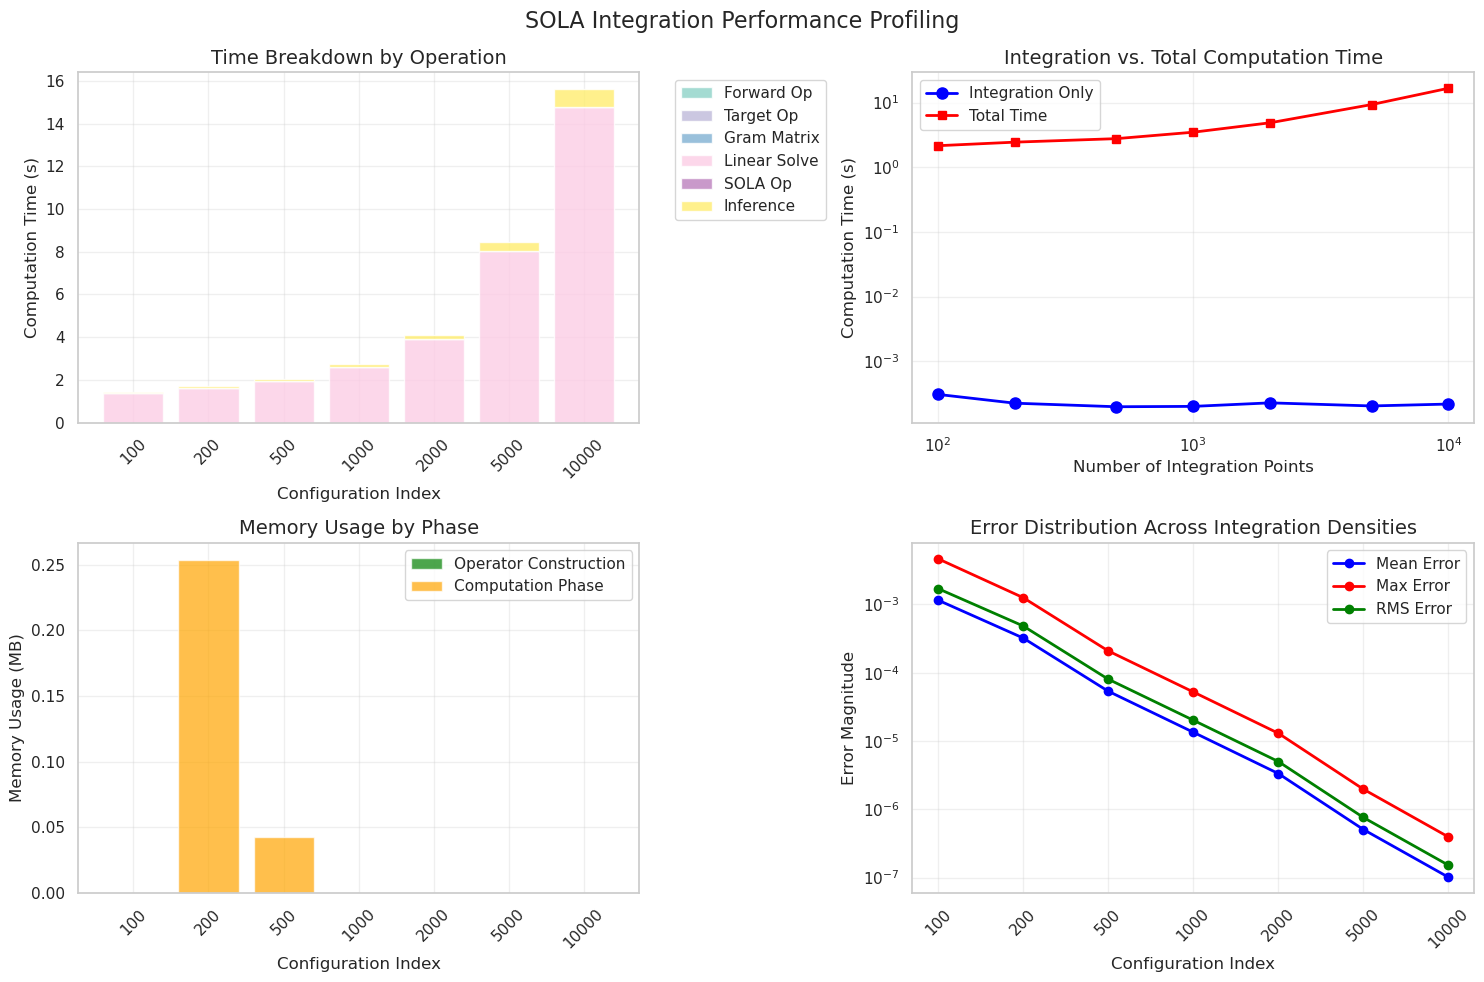

In [21]:
# Detailed performance profiling
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SOLA Integration Performance Profiling', fontsize=16)

# Time breakdown by operation
ax = axes[0, 0]
timing_cols = ['time_forward', 'time_target', 'time_gram', 'time_solve', 'time_sola', 'time_inference']
timing_labels = ['Forward Op', 'Target Op', 'Gram Matrix', 'Linear Solve', 'SOLA Op', 'Inference']
colors = plt.cm.Set3(np.linspace(0, 1, len(timing_cols)))

bottom = np.zeros(len(integration_results))
for i, (col, label) in enumerate(zip(timing_cols, timing_labels)):
    ax.bar(range(len(integration_results)), integration_results[col],
           bottom=bottom, label=label, color=colors[i], alpha=0.8)
    bottom += integration_results[col]

ax.set_xlabel('Configuration Index', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Time Breakdown by Operation', fontsize=14)
ax.set_xticks(range(len(integration_results)))
ax.set_xticklabels([f'{n}' for n in integration_results['n_points']], rotation=45)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Integration time vs. total time
ax = axes[0, 1]
ax.loglog(integration_results['n_points'], integration_results['time_integration'],
         'o-', linewidth=2, markersize=8, color='blue', label='Integration Only')
ax.loglog(integration_results['n_points'], integration_results['total_time'],
         's-', linewidth=2, markersize=6, color='red', label='Total Time')

ax.set_xlabel('Number of Integration Points', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Integration vs. Total Computation Time', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Memory usage analysis
ax = axes[1, 0]
ax.bar(range(len(integration_results)), integration_results['memory_ops_delta'],
       alpha=0.7, color='green', label='Operator Construction')
ax.bar(range(len(integration_results)),
       integration_results['memory_delta'] - integration_results['memory_ops_delta'],
       bottom=integration_results['memory_ops_delta'],
       alpha=0.7, color='orange', label='Computation Phase')

ax.set_xlabel('Configuration Index', fontsize=12)
ax.set_ylabel('Memory Usage (MB)', fontsize=12)
ax.set_title('Memory Usage by Phase', fontsize=14)
ax.set_xticks(range(len(integration_results)))
ax.set_xticklabels([f'{n}' for n in integration_results['n_points']], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Error distribution analysis
ax = axes[1, 1]
error_types = ['integration_error_mean', 'integration_error_max', 'integration_error_rms']
error_labels = ['Mean Error', 'Max Error', 'RMS Error']
error_colors = ['blue', 'red', 'green']

for i, (col, label, color) in enumerate(zip(error_types, error_labels, error_colors)):
    ax.semilogy(range(len(integration_results)), integration_results[col],
               'o-', linewidth=2, markersize=6, color=color, label=label)

ax.set_xlabel('Configuration Index', fontsize=12)
ax.set_ylabel('Error Magnitude', fontsize=12)
ax.set_title('Error Distribution Across Integration Densities', fontsize=14)
ax.set_xticks(range(len(integration_results)))
ax.set_xticklabels([f'{n}' for n in integration_results['n_points']], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'integration_profiling.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'integration_profiling.pdf'), bbox_inches='tight')
plt.show()

## Integration Recommendations

### Optimal Integration Point Selection

Based on our analysis, we provide recommendations for choosing integration density in different scenarios.

In [22]:
# Generate comprehensive recommendations
print("SOLA INTEGRATION POINTS BENCHMARKING - ANALYSIS REPORT")
print("=" * 65)
print()

# Summary statistics
print("SUMMARY STATISTICS:")
print(f"Integration points tested: {INTEGRATION_POINTS}")
print(f"Reference integration points: {ref_integration_points}")
print(f"Total benchmark time: {total_time:.2f} seconds")
print(f"Fixed configuration: {BASIS_TYPE} basis with N={N_BASIS} functions")
print()

# Convergence analysis
if len(integration_results) > 1:
    # Find convergence point (where improvement becomes marginal)
    errors = integration_results['integration_error_mean'].values
    relative_improvements = np.abs(np.diff(errors)) / errors[:-1] * 100

    convergence_threshold = 1.0  # 1% improvement threshold
    converged_idx = np.where(relative_improvements < convergence_threshold)[0]

    if len(converged_idx) > 0:
        convergence_point = integration_results.iloc[converged_idx[0] + 1]
        print(f"CONVERGENCE ANALYSIS:")
        print(f"Convergence achieved at: {convergence_point['n_points']} integration points")
        print(f"Final error: {convergence_point['integration_error_mean']:.8f}")
        print(f"Time to convergence: {convergence_point['total_time']:.3f}s")
        print()

# Find optimal configurations
best_accuracy = integration_results.loc[integration_results['integration_error_mean'].idxmin()]
fastest = integration_results.loc[integration_results['total_time'].idxmin()]
most_efficient = integration_results.loc[efficiency.idxmax()]

print("OPTIMAL CONFIGURATIONS:")
print("-" * 25)
print(f"Best Accuracy:")
print(f"  Integration points: {best_accuracy['n_points']}")
print(f"  Error: {best_accuracy['integration_error_mean']:.8f}")
print(f"  Time: {best_accuracy['total_time']:.3f}s")
print(f"  Memory: {best_accuracy['memory_delta']:.1f}MB")
print()

print(f"Fastest Execution:")
print(f"  Integration points: {fastest['n_points']}")
print(f"  Error: {fastest['integration_error_mean']:.8f}")
print(f"  Time: {fastest['total_time']:.3f}s")
print(f"  Memory: {fastest['memory_delta']:.1f}MB")
print()

print(f"Best Efficiency (Accuracy/Time):")
print(f"  Integration points: {most_efficient['n_points']}")
print(f"  Error: {most_efficient['integration_error_mean']:.8f}")
print(f"  Time: {most_efficient['total_time']:.3f}s")
print(f"  Efficiency score: {efficiency.max():.2f}")
print()

# Scaling analysis
if len(integration_results) > 1:
    log_n = np.log(integration_results['n_points'])
    log_time = np.log(integration_results['time_integration'])
    log_error = np.log(integration_results['integration_error_mean'])

    time_scaling = np.polyfit(log_n, log_time, 1)[0]
    error_scaling = np.polyfit(log_n, log_error, 1)[0]

    print("SCALING ANALYSIS:")
    print("-" * 17)
    print(f"Integration time scaling: O(N^{time_scaling:.2f})")
    print(f"Error convergence rate: O(N^{error_scaling:.2f})")
    print(f"Theoretical expectation: O(N) time, O(N^-2) error")
    print()

# Practical recommendations
print("PRACTICAL RECOMMENDATIONS:")
print("-" * 28)
print("1. FOR PROTOTYPING AND TESTING:")
print(f"   Use {fastest['n_points']} integration points")
print(f"   Provides reasonable accuracy ({fastest['integration_error_mean']:.6f}) with fast execution")
print()

print("2. FOR PRODUCTION APPLICATIONS:")
print(f"   Use {most_efficient['n_points']} integration points")
print(f"   Optimal balance of accuracy and computational cost")
print()

print("3. FOR HIGHEST ACCURACY REQUIREMENTS:")
print(f"   Use {best_accuracy['n_points']} integration points")
print(f"   Minimal error at the cost of increased computation time")
print()

print("4. GENERAL GUIDELINES:")
integration_overhead = np.mean(integration_results['time_integration'] / integration_results['total_time']) * 100
print(f"   - Integration overhead averages {integration_overhead:.1f}% of total computation")
print(f"   - Memory usage scales approximately linearly with integration points")
print(f"   - Diminishing returns beyond {convergence_point['n_points'] if 'convergence_point' in locals() else 'N/A'} points")
print(f"   - Consider problem-specific accuracy requirements vs. computational budget")

# Save detailed analysis
analysis_summary = {
    'optimal_accuracy': int(best_accuracy['n_points']),
    'optimal_speed': int(fastest['n_points']),
    'optimal_efficiency': int(most_efficient['n_points']),
    'convergence_point': int(convergence_point['n_points']) if 'convergence_point' in locals() else None,
    'time_scaling_exponent': time_scaling if 'time_scaling' in locals() else None,
    'error_scaling_exponent': error_scaling if 'error_scaling' in locals() else None,
    'average_integration_overhead_percent': integration_overhead
}

import json
with open(os.path.join(output_dir, 'integration_analysis_summary.json'), 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print(f"\nDetailed analysis saved to: {output_dir}/")
print("\n✓ Integration points benchmarking study completed successfully!")

SOLA INTEGRATION POINTS BENCHMARKING - ANALYSIS REPORT

SUMMARY STATISTICS:
Integration points tested: [100, 200, 500, 1000, 2000, 5000, 10000]
Reference integration points: 20000
Total benchmark time: 42.21 seconds
Fixed configuration: sine basis with N=30 functions

OPTIMAL CONFIGURATIONS:
-------------------------
Best Accuracy:
  Integration points: 10000.0
  Error: 0.00000010
  Time: 16.667s
  Memory: 0.0MB

Fastest Execution:
  Integration points: 100.0
  Error: 0.00115773
  Time: 2.154s
  Memory: 0.0MB

Best Efficiency (Accuracy/Time):
  Integration points: 10000.0
  Error: 0.00000010
  Time: 16.667s
  Efficiency score: 592688.17

SCALING ANALYSIS:
-----------------
Integration time scaling: O(N^-0.05)
Error convergence rate: O(N^-2.02)
Theoretical expectation: O(N) time, O(N^-2) error

PRACTICAL RECOMMENDATIONS:
----------------------------
1. FOR PROTOTYPING AND TESTING:
   Use 100.0 integration points
   Provides reasonable accuracy (0.001158) with fast execution

2. FOR PROD